#### Data の概要

In [1]:
import pandas as pd

log_df = pd.read_csv('access_log.csv', parse_dates=['date'])
print(log_df.shape)
log_df.head()

(325908, 3)


,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04
3,4,790055,2015-07-04
4,4,764638,2015-07-04


Column:
- User_id: User の Unique ID で、正の整数値をとる
- item_id: 商品の Unique ID で、正の整数値をとる
- date: User が商品を閲覧した日付。yyyy-mm-dd の形式をとる。

In [2]:
# User が期間内でどのくらい商品を閲覧を知るために User の商品の閲覧数の分布を確認
log_df['user_id'].value_counts().describe()

count    31443.000000
mean        10.365042
std         16.023399
min          2.000000
25%          3.000000
50%          5.000000
75%         11.000000
max        632.000000
Name: user_id, dtype: float64

<AxesSubplot:>

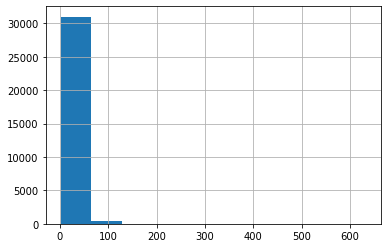

In [3]:
log_df['user_id'].value_counts().hist()

- count から Unique user 数
- mean から平均閲覧数
- 50% から商品閲覧数の中央値

が確認とれる。
最大で 632 回商品を閲覧している Heavy user もいるため、平均値と中央値に大きなズレが生じている。

In [4]:
# 商品が期間内でどのくらい User に閲覧されているかを知るために、商品を閲覧した User 数の分布を確認
log_df['item_id'].value_counts().describe()

count    87611.000000
mean         3.719944
std          8.802572
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        941.000000
Name: item_id, dtype: float64

<AxesSubplot:>

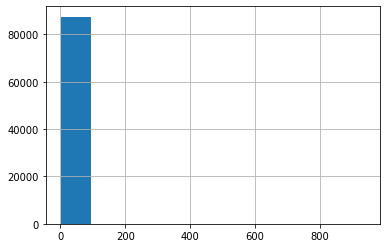

In [5]:
log_df['item_id'].value_counts().hist()

- count から商品数
- mean から１商品あたりの閲覧数の平均
- 50% から１商品あたりの閲覧数の中央値

が確認とれる。
最大で 941 回、閲覧されている人気商品があることが確認とれる。

In [6]:
# 閲覧履歴の期間とその商品閲覧数のばらつきを確認
log_df['date'].value_counts()

2015-07-03    45441
2015-07-02    45394
2015-07-01    44163
2015-07-04    43804
2015-07-08    39933
2015-07-05    39932
2015-07-07    33930
2015-07-06    33311
Name: date, dtype: int64

<AxesSubplot:>

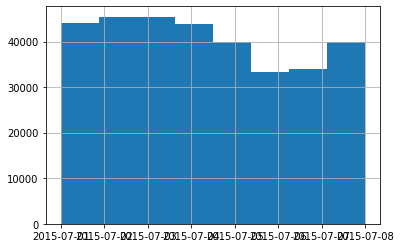

In [7]:
log_df['date'].hist(bins=8)

##### Data の概要
この Data は、EC mall の Tmall の閲覧履歴。
- 期間: 2015年07月01日 ~ 2015年07月08日までの８日間の Data.
- User数: 約３万人
- 期間内に閲覧された商品数: 約９万点
- User あたりの閲覧数: おおよそ５回
- 商品あたりの閲覧数: おおよそ２回

#### Data の性質
- Recency に関する単調性: User は最近閲覧した商品ほど興味がある。
- Frequency に関する単調性: User は何度も閲覧した商品ほど興味がある。

取り扱う Data に上記の仮説が成り立つか確認する。

User の再閲覧確率を求めるために、2015年07月01日 ~ 2015年07月07日までの閲覧履歴をもとに07月08日に再閲覧する確率を集計して求める。

2015年07月01日から07月07日までの閲覧履歴の Data と07月08日に閲覧された商品の Data を分離

In [8]:
import datetime

start_date = datetime.datetime(2015, 7, 1)
end_date = datetime.datetime(2015, 7, 7)
target_date = datetime.datetime(2015, 7, 8)

In [9]:
# 2015年07月01日から07月07日までの閲覧履歴 Data を抽出
x_df = log_df[
    (start_date <= log_df['date'])
    & (log_df['date'] <= end_date)
    ]
print(x_df.shape)
x_df.head(3)

(285975, 3)


,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04


In [10]:
# 07月08日の閲覧履歴 Data を抽出
y_df = log_df[log_df['date'] == target_date]
print(y_df.shape)
y_df.head()

(39933, 3)


,user_id,item_id,date
103,94,603852,2015-07-08
104,94,28600,2015-07-08
105,94,987320,2015-07-08
106,94,109924,2015-07-08
107,94,886214,2015-07-08


In [11]:
# x_df から User が閲覧した商品に対して freq(頻度) と rcan(最新度) を算出
U2IRcens = {}
for row in x_df.itertuples():
    # 最新度（経過日数）の算出: 基準日 - 最終閲覧日
    rcen = (target_date - row.date).days

    # 辞書に最新度を登録
    U2IRcens.setdefault(row.user_id, {})
    U2IRcens[row.user_id].setdefault(row.item_id, [])
    U2IRcens[row.user_id][row.item_id].append(rcen)

In [12]:
U2IRcens[2497]

{400521: [4, 2, 2, 2, 1], 678277: [4], 687963: [2], 178138: [1]}

User_id: 2497　の商品閲覧状況は、
- item_id: 400521 => 4日前に１回、2日前に３回、1日前に１回、閲覧。
- item_id: 678277 => 4日前に１回、閲覧。
- item_id: 687963 => 2日前に１回、閲覧。
- item_id: 178138 => 1日前に１回、閲覧。

言い換えると
- item_id: 400521 => 閲覧数５回、直近１日前に閲覧された。
- item_id: 678277 => 閲覧数１回、直近で４日前に閲覧された。
- item_id: 687963 => 閲覧数１回、直近で２日前に閲覧された。
- item_id: 178138 => 閲覧数１回、直近で１日前に閲覧された。

In [13]:
# freq（頻度）とrcen（最新度）を追加した Data を作成
Rowsl = []
for user_id, I2Rcens in U2IRcens.items():
    for item_id, Rcens in I2Rcens.items():
        freq = len(Rcens)
        rcen = min(Rcens)
        Rowsl.append((user_id, item_id, rcen, freq))

UI2RF_df = pd.DataFrame(Rowsl, columns=['user_id', 'item_id', 'rcen', 'freq'])
print(UI2RF_df.shape)
UI2RF_df.head()


(204661, 4)


,user_id,item_id,rcen,freq
0,4,205587,4,1
1,4,748683,4,1
2,4,790055,4,3
3,4,764638,4,2
4,4,492434,4,1


In [14]:
# 07月08日

#### Data の性質
- Recency に関する単調性: User は最近閲覧した商品ほど興味がある。
- Frequency に関する単調性: User は何度も閲覧した商品ほど興味がある。

取り扱う Data に上記の仮説が成り立つか確認する。

User の再閲覧確率を求めるために、2015年07月01日 ~ 2015年07月07日までの閲覧履歴をもとに07月08日に再閲覧する確率を集計して求める。

2015年07月01日から07月07日までの閲覧履歴の Data と07月08日に閲覧された商品の Data を分離

In [15]:
import datetime

start_date = datetime.datetime(2015, 7, 1)
end_date = datetime.datetime(2015, 7, 7)
target_date = datetime.datetime(2015, 7, 8)

In [16]:
# 2015年07月01日から07月07日までの閲覧履歴 Data を抽出
x_df = log_df[
    (start_date <= log_df['date'])
    & (log_df['date'] <= end_date)
    ]
print(x_df.shape)
x_df.head(3)

(285975, 3)


,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04


In [17]:
# 07月08日の閲覧履歴 Data を抽出
y_df = log_df[log_df['date'] == target_date]
print(y_df.shape)
y_df.head()

(39933, 3)


,user_id,item_id,date
103,94,603852,2015-07-08
104,94,28600,2015-07-08
105,94,987320,2015-07-08
106,94,109924,2015-07-08
107,94,886214,2015-07-08


In [18]:
# x_df から User が閲覧した商品に対して freq(頻度) と rcan(最新度) を算出
U2IRcens = {}
for row in x_df.itertuples():
    # 最新度（経過日数）の算出: 基準日 - 最終閲覧日
    rcen = (target_date - row.date).days

    # 辞書に最新度を登録
    U2IRcens.setdefault(row.user_id, {})
    U2IRcens[row.user_id].setdefault(row.item_id, [])
    U2IRcens[row.user_id][row.item_id].append(rcen)

In [19]:
U2IRcens[2497]

{400521: [4, 2, 2, 2, 1], 678277: [4], 687963: [2], 178138: [1]}

User_id: 2497　の商品閲覧状況は、
- item_id: 400521 => 4日前に１回、2日前に３回、1日前に１回、閲覧。
- item_id: 678277 => 4日前に１回、閲覧。
- item_id: 687963 => 2日前に１回、閲覧。
- item_id: 178138 => 1日前に１回、閲覧。

言い換えると
- item_id: 400521 => 閲覧数５回、直近１日前に閲覧された。
- item_id: 678277 => 閲覧数１回、直近で４日前に閲覧された。
- item_id: 687963 => 閲覧数１回、直近で２日前に閲覧された。
- item_id: 178138 => 閲覧数１回、直近で１日前に閲覧された。

In [20]:
# freq（頻度）とrcen（最新度）を追加した Data を作成
Rowsl = []
for user_id, I2Rcens in U2IRcens.items():
    for item_id, Rcens in I2Rcens.items():
        freq = len(Rcens)
        rcen = min(Rcens)
        Rowsl.append((user_id, item_id, rcen, freq))

UI2RF_df = pd.DataFrame(Rowsl, columns=['user_id', 'item_id', 'rcen', 'freq'])
print(UI2RF_df.shape)
UI2RF_df.head()


(204661, 4)


,user_id,item_id,rcen,freq
0,4,205587,4,1
1,4,748683,4,1
2,4,790055,4,3
3,4,764638,4,2
4,4,492434,4,1


In [21]:
# 7月8日の Data `y_df` の重複を取り除き、pv_flag の Column を追加する
y_df = y_df.drop_duplicates()
print(y_df.shape)
y_df['pv_flag'] = 1
y_df

(29651, 3)


,user_id,item_id,date,pv_flag
103,94,603852,2015-07-08,1
104,94,28600,2015-07-08,1
105,94,987320,2015-07-08,1
106,94,109924,2015-07-08,1
107,94,886214,2015-07-08,1
...,...,...,...,...
325676,423919,707537,2015-07-08,1
325679,423919,692138,2015-07-08,1
325682,423919,617597,2015-07-08,1
325715,423958,963019,2015-07-08,1


In [22]:
# UI2FR_df に user_id と item_id を key として y_df を merge
UI2RFP_df = pd.merge(UI2RF_df, y_df[['user_id', 'item_id', 'pv_flag']], how='left', on=['user_id', 'item_id'])
UI2RFP_df['pv_flag'].fillna(0, inplace=True)
print(UI2RFP_df.shape)
UI2RFP_df.head()

(204661, 5)


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [23]:
# rcen と freq がどのような値をとるか確認
print(sorted(UI2RFP_df['rcen'].unique()))
print(sorted(UI2RFP_df['freq'].unique()))

[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 34, 35, 41, 43, 58, 63, 118]


rcen: 定義域が 1 ~ 7 (※閲覧履歴が7月1日から7月7日までの期間で切れているため)
freq: 期間中何度でも商品を閲覧できるので最大値が 118 になっている。

In [24]:
# 今回は、わかりやすさのため freq の定義域を rcen との規模感に合わせ、7以下となるように Filtering し、目標となる Data を `tar_df` を作成
tar_df = UI2RFP_df[UI2RFP_df['freq'] <= 7]
print(tar_df.shape)
tar_df.head()

(203456, 5)


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [25]:
# pv_flag の規模感を確認
print(tar_df['pv_flag'].sum())

2038.0


7月1日から7月7日までの期間に閲覧された商品のなかで、7月8日に再閲覧された商品は 2,038件ある様子

In [26]:
# Data が Recency と Frequency の単調性をもつことを確認

# rcen に対して、7月8日に閲覧したか (pos)、閲覧しなかったか (neg) について Cross集計
rcen_df = pd.crosstab(index=tar_df['rcen'], columns=tar_df['pv_flag'])
rcen_df = rcen_df.rename(columns= {0: 'neg', 1: 'pos'})
rcen_df

pv_flag,neg,pos
rcen,,
1,24595,571
2,24032,274
3,28212,326
4,30641,275
5,31510,225
6,31721,199
7,30707,168


pv_flag,neg,pos,N,prob
rcen,,,,
1,24595,571,25166,0.022689
2,24032,274,24306,0.011273
3,28212,326,28538,0.011423
4,30641,275,30916,0.008895
5,31510,225,31735,0.007090
6,31721,199,31920,0.006234
7,30707,168,30875,0.005441


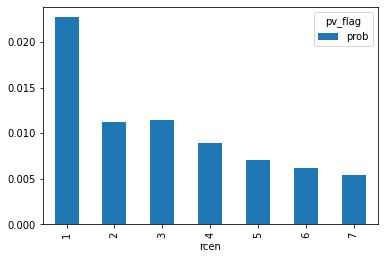

In [27]:
# 各rcen に対して総件数を N として、再閲覧率 prob を算出
rcen_df['N'] = rcen_df['neg'] + rcen_df['pos']
rcen_df['prob'] = rcen_df['pos'] / rcen_df['N']
rcen_df[['prob']].plot.bar()
rcen_df

- rcen に対して再閲覧率 prob が単調減少の傾向がある

=> 最近で閲覧した商品ほど再度閲覧されると解釈できる。

In [28]:
# freq に対して、7月8日に閲覧したか (pos), 閲覧しなかったか (neg) について Cross集計
freq_df = pd.crosstab(index=tar_df['freq'], columns=tar_df['pv_flag'])
freq_df = freq_df.rename(columns={0: 'neg', 1: 'pos'})
freq_df

pv_flag,neg,pos
freq,,
1,161753,964
2,24938,476
3,7733,258
4,3527,149
5,1807,88
6,1038,63
7,622,40


pv_flag,neg,pos,N,prob
freq,,,,
1,161753,964,162717,0.005924
2,24938,476,25414,0.018730
3,7733,258,7991,0.032286
4,3527,149,3676,0.040533
5,1807,88,1895,0.046438
6,1038,63,1101,0.057221
7,622,40,662,0.060423


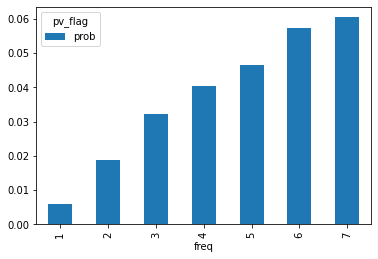

In [29]:
# 各 freq に対して総件数を N として、再閲覧率 prob を算出
freq_df['N'] = freq_df['neg'] + freq_df['pos']
freq_df['prob'] = freq_df['pos'] / freq_df['N']
freq_df[['prob']].plot.bar()
freq_df

- freq に対して prob が単調増加の傾向

=> 何度も閲覧した商品ほど再度閲覧される、と解釈できる

対象とする Data において、Recency と Frequency の単調性が成立すると判断できる。